In [2]:
import numpy as np
import pandas as pd


In [7]:
df = pd.read_csv("feature selection\mobile_dataset.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [9]:
x = df.drop("price_range", axis=1)
y = df["price_range"]

In [13]:

def explore_dataset(df):
    print(f"Shape: {df.shape}")
    print(f"\nColumn dtypes:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nBasic stats:\n{df.describe()}")
    return df.info()

explore_dataset(df)

Shape: (2000, 21)

Column dtypes:
battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

Missing values:
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int6

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


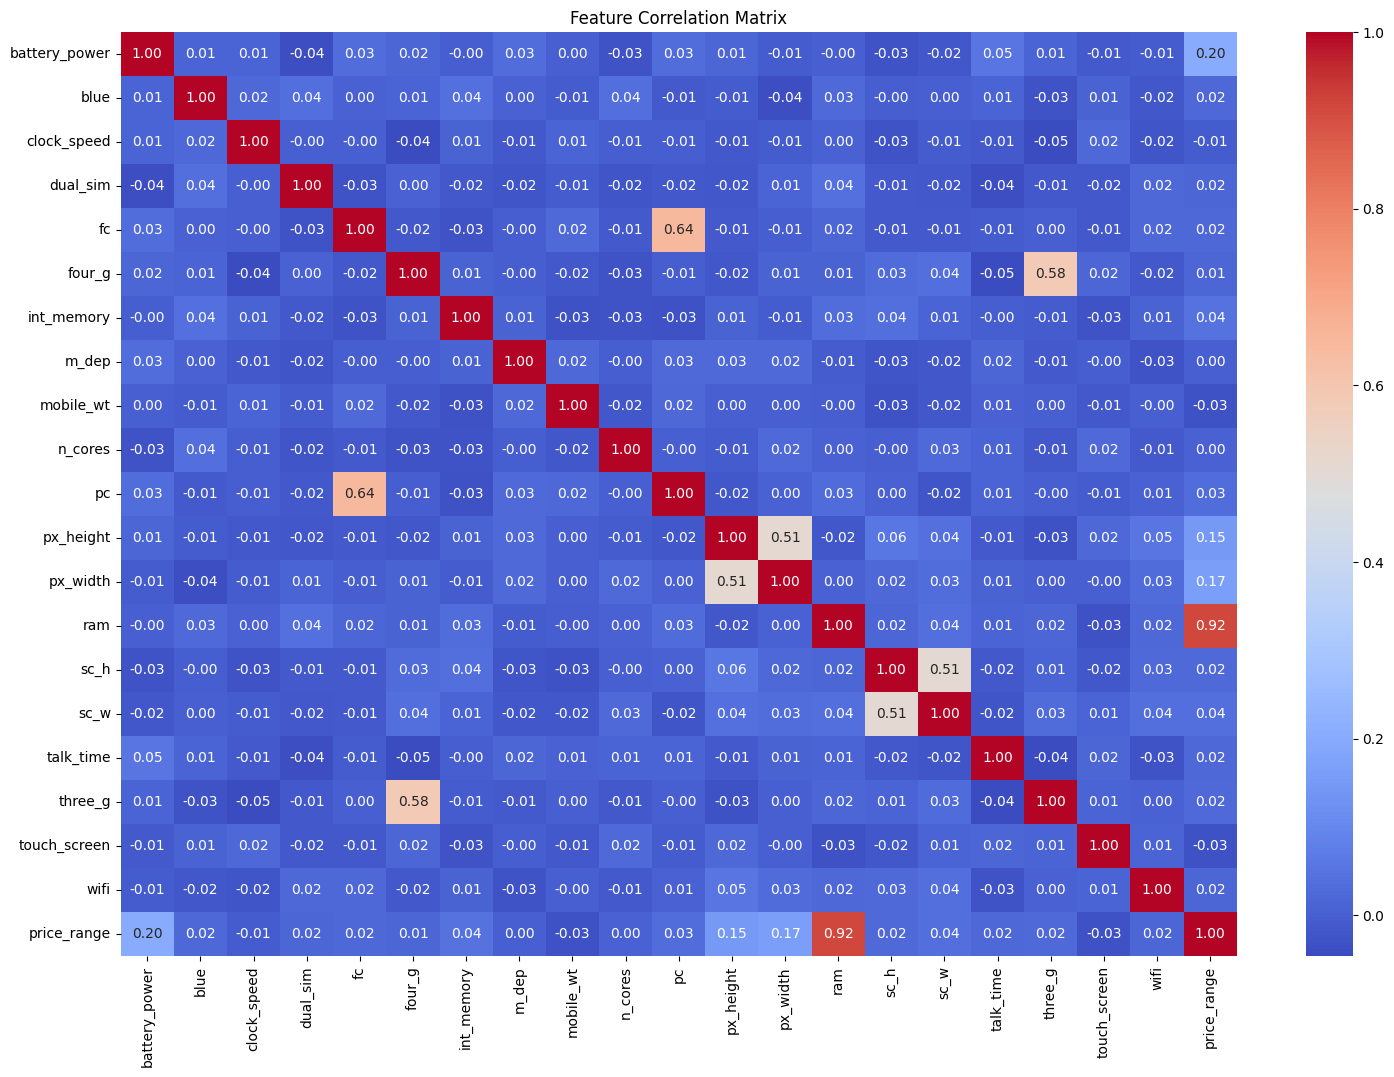

Low variance features: Index([], dtype='object')


In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Check target distribution
print(df['price_range'].value_counts())

# 2. Correlation analysis
plt.figure(figsize=(18, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# 3. Check feature variance (remove constant features)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
selector.fit(df.drop('price_range', axis=1))
print(f"Low variance features: {df.drop('price_range', axis=1).columns[~selector.get_support()]}")

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Select top 10 features (choose one method)
def get_top_features(df, method='correlation'):
    X = df.drop('price_range', axis=1)
    y = df['price_range']
    
    if method == 'correlation':
        corr = df.corr()['price_range'].abs().sort_values(ascending=False)
        top_features = corr[1:11].index.tolist()
    
    elif method == 'anova':
        from sklearn.feature_selection import SelectKBest, f_classif
        selector = SelectKBest(score_func=f_classif, k=10)
        selector.fit(X, y)
        top_features = X.columns[selector.get_support()].tolist()
    
    elif method == 'expert':
        # Based on domain knowledge and similar datasets
        top_features = [
            'ram', 'battery_power', 'px_width', 'px_height',
            'int_memory', 'mobile_wt', 'sc_w', 'sc_h', 'fc', 'pc'
        ]
    
    return top_features

# Get features
top_features = get_top_features(df, method='correlation')
print("Selected features for model:", top_features)

# Prepare data
X = df[top_features]
y = df['price_range']

# Scale features (important for regression models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression (for classification)
model = LogisticRegression(
    multi_class='multinomial',  # For 4 price categories
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature coefficients (importance in regression)
coefficients = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': model.coef_[0]  # For multi-class, check all classes
})
print("\nFeature Coefficients (importance):")
print(coefficients.sort_values('Coefficient', key=abs, ascending=False))

Selected features for model: ['ram', 'battery_power', 'px_width', 'px_height', 'int_memory', 'sc_w', 'pc', 'touch_screen', 'mobile_wt', 'three_g']

Model Accuracy: 0.9825

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.98      0.98      0.98       100
           2       0.97      0.96      0.96       100
           3       0.98      0.99      0.99       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400


Feature Coefficients (importance):
         Feature  Coefficient
0            ram   -10.905650
1  battery_power    -2.730467
3      px_height    -1.584593
2       px_width    -1.546600
8      mobile_wt     0.420539
4     int_memory    -0.181688
5           sc_w    -0.060754
7   touch_screen     0.036428
9        three_g    -0.013786
6             pc    -0.005665


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
